## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [39]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import time


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [40]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [41]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [42]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [43]:
len(fmnist_dataset_test)

10000

In [44]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [196]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 200),
            nn.BatchNorm1d(200),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [197]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
       BatchNorm1d-3                  [-1, 200]             400
           Dropout-4                  [-1, 200]               0
              ReLU-5                  [-1, 200]               0
            Linear-6                  [-1, 100]          20,100
           Dropout-7                  [-1, 100]               0
              ReLU-8                  [-1, 100]               0
            Linear-9                   [-1, 10]           1,010
       LogSoftmax-10                   [-1, 10]               0
Total params: 178,510
Trainable params: 178,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.68
Estimated T

Your experiments come here:

In [198]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [192]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            out = model(X_batch)
            loss = loss_fn(out, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
                out = model(X_batch)
                loss = loss_fn(out, y_batch)


                # compute predictions
                ep_val_loss.append(loss.item())
                y_pred = out.max(dim=1)[1]
                ep_val_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu().numpy().astype(float))/ len(y_batch.cpu()))
        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")
    return train_loss, val_loss, val_accuracy

In [199]:
n_epochs = 30
train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 5 took 4.154s
	  training loss: 0.648246
	validation loss: 0.435826
	validation accuracy: 0.838
Epoch 2 of 5 took 4.019s
	  training loss: 0.477166
	validation loss: 0.395347
	validation accuracy: 0.855
Epoch 3 of 5 took 4.234s
	  training loss: 0.442970
	validation loss: 0.397030
	validation accuracy: 0.853
Epoch 4 of 5 took 4.036s
	  training loss: 0.421130
	validation loss: 0.373181
	validation accuracy: 0.865
Epoch 5 of 5 took 4.064s
	  training loss: 0.406724
	validation loss: 0.361805
	validation accuracy: 0.865


In [ ]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

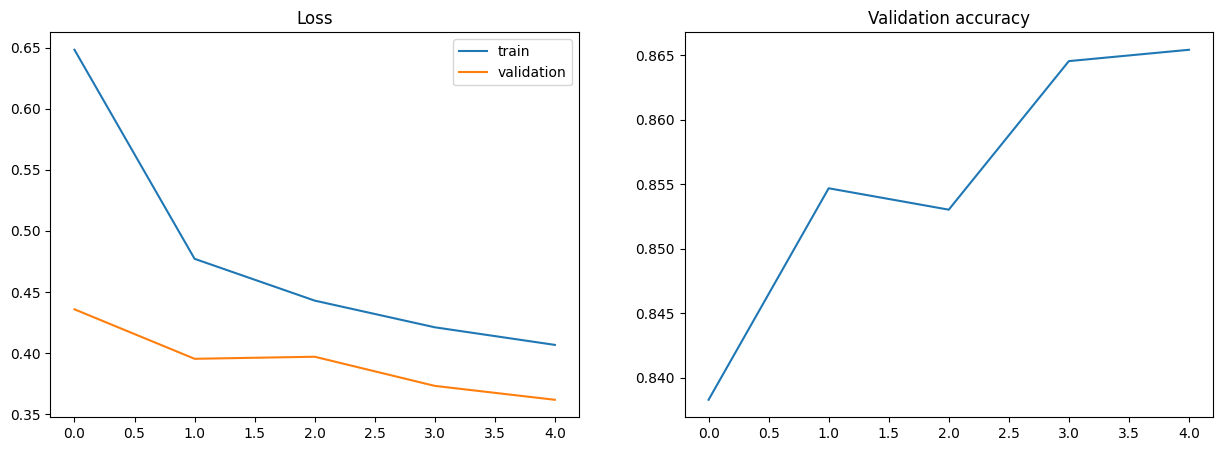

In [200]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 200),
            nn.BatchNorm1d(200),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
       BatchNorm1d-3                  [-1, 200]             400
           Dropout-4                  [-1, 200]               0
              ReLU-5                  [-1, 200]               0
            Linear-6                  [-1, 100]          20,100
           Dropout-7                  [-1, 100]               0
              ReLU-8                  [-1, 100]               0
            Linear-9                   [-1, 10]           1,010
       LogSoftmax-10                   [-1, 10]               0
Total params: 178,510
Trainable params: 178,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.68
Estimated T

In [ ]:
fmnist_dataset_train_new = [fmnist_dataset_train[i] for i in range(len(fmnist_dataset_train)) if i <= 1000]
train_loader_for_overfit = torch.utils.data.DataLoader(fmnist_dataset_train_new,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

# model = OverfittingNeuralNetwork().to(device)
# opt = torch.optim.Adam(model.parameters())
# loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
n_epochs = 100
train_loss, val_loss, val_accuracy = train_model(model, train_loader_for_overfit, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 100 took 0.712s
	  training loss: 0.237036
	validation loss: 0.353966
	validation accuracy: 0.874
Epoch 2 of 100 took 0.733s
	  training loss: 0.202853
	validation loss: 0.358508
	validation accuracy: 0.871
Epoch 3 of 100 took 0.795s
	  training loss: 0.168264
	validation loss: 0.357044
	validation accuracy: 0.873
Epoch 4 of 100 took 0.748s
	  training loss: 0.146281
	validation loss: 0.356274
	validation accuracy: 0.873
Epoch 5 of 100 took 0.765s
	  training loss: 0.132142
	validation loss: 0.364936
	validation accuracy: 0.871
Epoch 6 of 100 took 0.734s
	  training loss: 0.118637
	validation loss: 0.373225
	validation accuracy: 0.871


Exception ignored in: <function _releaseLock at 0x7ff4b60897e0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


Epoch 7 of 100 took 0.793s
	  training loss: 0.108679
	validation loss: 0.380958
	validation accuracy: 0.872
Epoch 8 of 100 took 0.825s
	  training loss: 0.093670
	validation loss: 0.388960
	validation accuracy: 0.869
Epoch 9 of 100 took 0.780s
	  training loss: 0.086777
	validation loss: 0.400407
	validation accuracy: 0.865
Epoch 10 of 100 took 0.726s
	  training loss: 0.071424
	validation loss: 0.408455
	validation accuracy: 0.866
Epoch 11 of 100 took 0.776s
	  training loss: 0.065003
	validation loss: 0.419399
	validation accuracy: 0.865
Epoch 12 of 100 took 0.854s
	  training loss: 0.054792
	validation loss: 0.430445
	validation accuracy: 0.866
Epoch 13 of 100 took 0.791s
	  training loss: 0.052007
	validation loss: 0.438885
	validation accuracy: 0.866
Epoch 14 of 100 took 0.773s
	  training loss: 0.052461
	validation loss: 0.453449
	validation accuracy: 0.863
Epoch 15 of 100 took 0.784s
	  training loss: 0.041487
	validation loss: 0.458914
	validation accuracy: 0.864
Epoch 16 of 1

KeyboardInterrupt: 

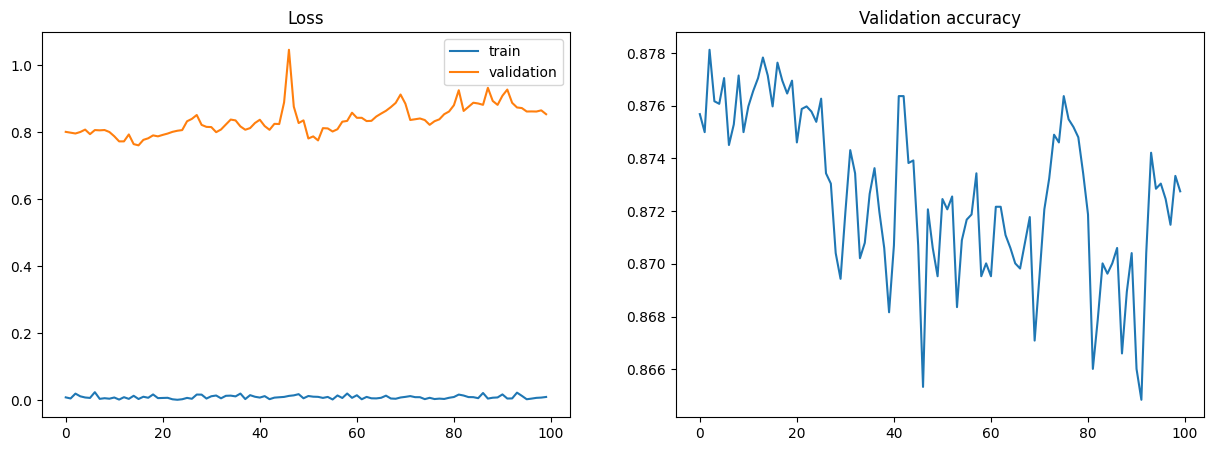

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 200),
            nn.BatchNorm1d(200),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100, num_classes),
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [ ]:
model = FixedNeuralNetwork().to(device)
opt = # YOUR CODE HERE
loss_func = # YOUR CODE HERE

# Your experiments, come here

SyntaxError: invalid syntax (2188921326.py, line 2)

### Conclusions:
_Write down small report with your conclusions and your ideas._